<div align="right" style="text-align: right"><i>Peter Norvig<br>July 2021</i></div>

# Climbing Wall

From the 538 Riddler's [23 July 2021 issue](https://fivethirtyeight.com/features/can-you-hop-across-the-chessboard/):

>Today marks the beginning of the Summer Olympics! One of the brand-new events this year is sport climbing, in which competitors try their hands (and feet) at lead climbing, speed climbing and bouldering.
>
>Suppose the event’s organizers accidentally forgot to place all the climbing holds on and had to do it last-minute for their 10-meter wall (the regulation height for the purposes of this riddle). Climbers won’t have any trouble moving horizontally along the wall. However, climbers can’t move between holds that are more than 1 meter apart vertically.
>
>In a rush, the organizers place climbing holds randomly until there are no vertical gaps between climbing holds (including the bottom and top of the wall). Once they are done placing the holds, how many will there be on average (not including the bottom and top of the wall)?

I'll define `place_holds` as a Monte Carlo simulation that selects uniform random hold locations until no gap is more than 1:

In [1]:
import random
from typing import List
from statistics import mean

def place_holds(top=10) -> List[float]:
    """Place holds on wall until no gap is more than 1."""
    holds = [0, top]
    while max(gaps(holds)) > 1:
        holds.append(random.uniform(0, top))
        holds.sort()
    return holds[1:-1] # (not including the bottom and top of the wall)
        
def gaps(numbers) -> List[float]:
    """The differences between adjacent pairs of sorted numbers."""
    return [numbers[i] - numbers[i - 1] for i in range(1, len(numbers))]

For example:

In [2]:
place_holds(4)

[0.2174318085529534,
 0.3246749454836446,
 0.6326268620662914,
 0.6381873992245448,
 0.6579032162296619,
 0.7250061911052263,
 1.0515460945502828,
 1.5119309951687048,
 2.15396033960555,
 2.7599575760459114,
 3.2936277160533924,
 3.2997054391317278,
 3.7149308611754135,
 3.803685937586361]

In [3]:
gaps(_)

[0.10724313693069121,
 0.30795191658264676,
 0.005560537158253442,
 0.019715817005117042,
 0.06710297487556449,
 0.32653990344505646,
 0.46038490061842197,
 0.6420293444368452,
 0.6059972364403614,
 0.533670140007481,
 0.0060777230783353176,
 0.41522542204368573,
 0.08875507641094771]

Now the Monte Carlo algorithm computes the mean number of holds over repeated simulations:

In [4]:
def monte_carlo(fn, *args, repeat=10_000, key=len) -> float:
    """Mean value of key(fn(*args)), repeated `repeat` times."""
    return mean(key(fn(*args)) for _ in range(repeat))

In [5]:
monte_carlo(place_holds)

43.014

**Answer:** The expected number of holds is about **43** (which I found surprisingly large).

# Extra Credit

> Now suppose climbers find it just as difficult to move horizontally as vertically, meaning they can’t move between any two holds that are more than 1 meter apart in any direction. Suppose also that the climbing wall is a 10-by-10 meter square. If the organizers again place the holds randomly, how many have to be placed on average until it’s possible to climb the wall?

I'll again do a Monte Carlo simulation, placing holds at uniform random locations on a 10-by-10 meter wall, until there is a path from the bottom to top. To help determine if there is a path, I'll keep track, for every hold, of the highest hold that can be reached from that hold. The data structure `Wall` will be a mapping of `{hold: highest_reachable_hold}`. When a new hold is added to the wall, we update highest reachable holds as follows: 
- Find all holds `hold2` that are within 1 meter of the new `hold`.
- We can now `merge` the holds reachable (transitively) from `hold` and those reachable from `hold2`.
- Let `new_max_hold` be the highest hold reachable by `hold` or `hold2`
- Update all the holds that are reachable from either `hold` or `hold2` to now reach `new_max_hold`.
- If we find a hold `h` that is within 1 meter of the bottom and can reach a hold within one meter of the top, add `h` to the `starts` set.



In [6]:
# A 2-D point is an (X, Y) tuple:
def X_(point): return point[0]
def Y_(point): return point[1]

class Wall(dict):
    """A Wall is a mapping of {hold: highest_reachable_hold}.
    Also keep track of `starts`: a set of holds that are within 1 
    of the bottom, and can reach to a hold within 1 of the top."""
    def __init__(self, top=10): 
        self.top = top
        self.starts = set()
    
    def add(self, hold):
        """Add hold to this `Wall`, and merge groups if needed."""
        self[hold] = hold
        for hold2 in self:
            if hold is not hold2 and distance(hold, hold2) <= 1:
                self.merge(hold, hold2)

    def merge(self, hold1, hold2):
        """Update the highest reachable hold for hold1, hold2, and all they can reach."""
        old_max_holds = self[hold1], self[hold2]
        new_max_hold = max(old_max_holds, key=Y_)
        for h in self:
            if self[h] in old_max_holds:
                self[h] = new_max_hold
                if self.top - Y_(new_max_hold) <= 1 and Y_(h) < 1:
                    self.starts.add(h)
    
def distance(A, B): return abs(complex(*A) - complex(*B))

*Note*: This could be made more efficient with a [kd-tree](https://en.wikipedia.org/wiki/K-d_tree) to see what holds are near each other, and a [union-find forest](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) to merge groups. But since the number of hold points is small, I opted for simplicity, not efficiency.

Now, we just need to keep adding random holds to the wall until there are one or more `wall.starts` holds: holds that are within 1 meter of the bottom and can attain a hold within 1 meter of the top. Then we can do a Monte Carlo simulation and find the mean number of holds.

In [7]:
def place_holds_2d(top=10) -> Wall:
    """Randomly place holds on wall until there is a path from bottom to top."""
    wall = Wall(top)
    while not wall.starts:
        wall.add((random.uniform(0, top), random.uniform(0, top)))
    return wall

In [8]:
monte_carlo(place_holds_2d, repeat=1000)

143.004

**Answer:** The expected number of holds is about **143** (which I found surprisingly small).

# Visualization

To get an idea what random walls look like, and to gain confidence in this program, I'll plot some walls, with red dots indicating the random holds, and dotted lines indicating possible paths from bottom to top.

In [9]:
import matplotlib.pyplot as plt

def plot_wall(wall):
    """Plot the holds on the wall, and the paths from bottom to top."""
    plt.gca().set_aspect('equal', adjustable='box')
    ends = {wall[h] for h in wall.starts}
    for h in wall:
        if wall[h] in ends:
            if Y_(h) <= 1:
                plot_points([h, (X_(h), 0)], 'k:')
            if wall.top - Y_(h) <= 1:
                plot_points([h, (X_(h), wall.top)], 'k:')
            for h2 in wall:
                if distance(h, h2) <= 1:
                    plot_points([h, h2], 'k:')
    plot_points(wall, 'r.')
    plt.title(f'holds: {len(wall)}; start points: {len(wall.starts)}')

def plot_points(points, fmt):
    """Plot (X, Y) points with given format."""
    plt.plot([X_(p) for p in points], [Y_(p) for p in points], fmt)

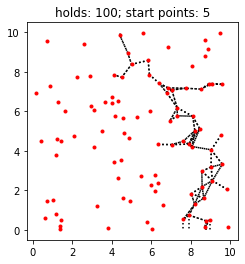

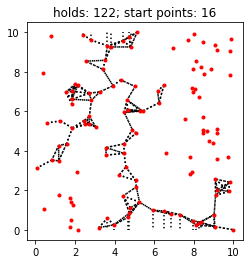

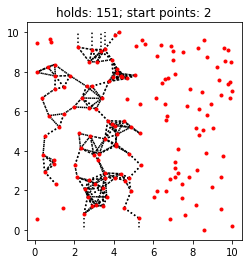

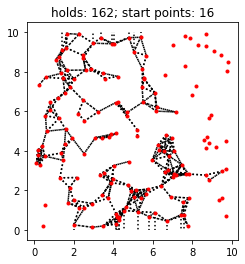

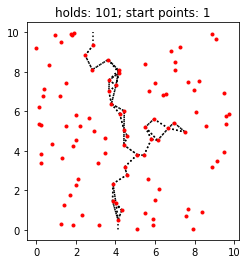

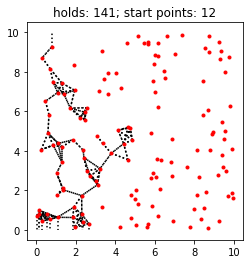

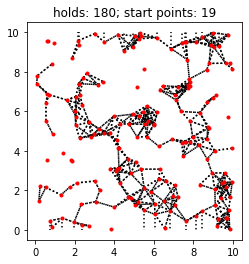

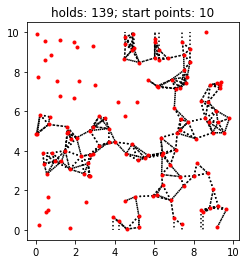

In [10]:
for i in range(8):
    plot_wall(place_holds_2d())
    plt.show()

# Different Size Walls

What if the wall had a size other than 10 meters? I would expect that the number of holds goes up roughly linearly on the 1-D wall, and roughly quadratically on the 2-D wall. I can plot expected number of holds for different wall heights, and fit a quadratic polynomial to the data: 

In [11]:
import numpy as np

def fit(X, fn, key=len, repeat=1_000, degree=2) -> np.array:
    """Fit key(fn(x)) to a polynomial; plot; return polynomial coefficients."""
    Y = [monte_carlo(fn, x, key=key, repeat=repeat) for x in X]
    coefs = np.polyfit(X, Y, 2)
    poly  = np.poly1d(coefs)
    plt.plot(X, Y, 'o-', label=fn.__name__);
    plt.plot(X, [poly(x) for x in X], '.:', label=poly_name(coefs))
    plt.legend()
    return coefs

def poly_name(parms) -> str:
    """A str representing a polynomial."""
    degree = len(parms) - 1
    return ' + '.join(term(coef, degree - i) for i, coef in enumerate(parms))

def term(coef, d) -> str: 
    """A str representing a term in a polynomial."""
    return f'{coef:.2f}' + ('' if d == 0 else 'x' if d == 1 else f'x^{d}')

First 1-D walls—we see the best-fit quadratic is almost a straight line with slope 4.5, but has a slight upward bend.

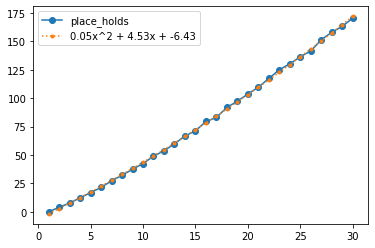

In [12]:
fit(range(1, 31), place_holds);

Now 2-D walls—we see a prominent quadratic shape:

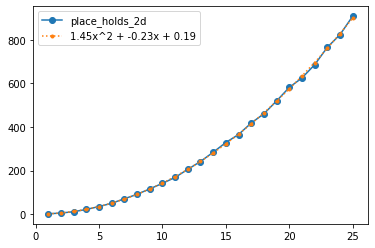

In [14]:
fit(range(1, 26), place_holds_2d, repeat=100);